# GNR -- Gandhi, Navarro, Rivers

# Summary of the GNR method: 

Derivation of the model: 

The firm's profit maximization problem with respect to intermediate inpouts is: 

$$
\max_{M_{jt}} P_t \mathbb E\left[F(k_{jt}, l_{jt}, m_{jt})e^{\omega_{jt}+ \epsilon_{jt}}\right] - \rho_t M_{jt}. 
$$

and the first-order condition is: 

$$
P_t \frac{\partial}{\partial M_{jt}}F(k_{jt}, l_{jt}, m_{jt})e^{\omega_{jt}} \mathcal E = \rho_t . 
$$

with $\mathcal E \equiv e^{\epsilon_{jt}}$. Take Logs: 

$$
\ln P_t +\ln\left(\frac{\partial}{\partial M_{jt}}F(k_{jt}, l_{jt}, m_{jt})\right) + {\omega_{jt}} + \ln \mathcal E = \ln \rho_t . 
$$

Now subtract $\ln Y_{jt} = \ln F(k_{jt}, l_{jt}, m_{jt}) + {\omega_{jt}} + \epsilon_{jt}$  from both sides

$$
\ln \mathcal E +\ln\left(\frac{\partial}{\partial M_{jt}}F(k_{jt}, l_{jt}, m_{jt})\right) - {\epsilon_{jt}}  = \ln \rho_t  - \ln P_t - \ln Y_{jt} + \ln F(k_{jt}, l_{jt}, m_{jt}) \equiv \ln \left(\frac{\rho_tF(k_{jt}, l_{jt}, m_{jt})}{P_tY_{jt}}\right). 
$$

Using the properties of log derivatives (where lowercase = logs)

$$
\ln\left(\frac{\partial}{\partial M_{jt}}F(k_{jt}, l_{jt}, m_{jt})\right) \equiv \ln\left(\frac{\partial}{\partial m_{jt}}f(k_{jt}, l_{jt}, m_{jt}) \cdot \frac{F(k_{jt}, l_{jt}, m_{jt})}{M_t}\right)
$$

Then moving the $\frac{F(k_{jt}, l_{jt}, m_{jt})}{M_t}$ to the other side we get


$$
\underbrace{\ln \mathcal E +\ln\left(\frac{\partial}{\partial m_{jt}}f(k_{jt}, l_{jt}, m_{jt})\right)}_{\ln D^\mathcal E} - {\epsilon_{jt}}  =  \ln \left(\frac{\rho_t M_{jt}}{P_tY_{jt}}\right),
$$ 

$$
{\ln D^\mathcal E}(k_{jt}, l_{jt}, m_{jt}) - {\epsilon_{jt}}  =  \ln \left(\frac{\rho_t M_{jt}}{P_tY_{jt}}\right) \equiv s_{jt},
$$ 

where $s_{jt}$ is the log intermediate share of output. 

## Estimation Procedure

First, we want to estimate the elasticity $D^{\mathcal E}(k_{jt}, l_{jt}, m_{jt}) = \operatorname{PolynomialFit}(k_{jt}, l_{jt}, m_{jt})$. To find the coefficients of the polynomials, we run the estimator 

$$
\min_{\gamma'} \sum_{j, t} \left\{  s_{jt} - \ln\underbrace{\begin{pmatrix} \gamma_0'+\gamma_k'k_{jt}+\gamma_l'l_{jt}+ \gamma_m' m_{jt} + \gamma_{kk}' k_{jt}^2 + \gamma_{ll}' l_{jt}^2 \\ \gamma_{mm}' m_{jt}^2 + \gamma_{kl}' k_{jt}l_{jt} + \gamma_{km}' k_{jt} m_{jt} + \gamma'_{lm} l_{jt} m_{jt}\end{pmatrix}}_{D^\mathcal E} \right\}^2
$$

where $s_{jt} \equiv \ln\left(\frac{\rho_t M_{jt}}{P_t Y_t}\right)$ is the log intermediate share of input. Then using the gamma coefficients, we get

$$\hat D_{jt} \equiv D^{\mathcal E}(k_{jt}, l_{jt}, m_{jt}) = \operatorname{Polynomial}(k_{jt}, l_{jt}, m_{jt} \big| \vec \gamma')$$

From there, get the residuals

$$ 
\hat \epsilon_{jt} =  \ln \hat D_{jt} - s_{jt}
$$


Next, estimate $\widehat{\mathcal E} = \frac{1}{JT}\sum_{j,t}e^{\hat \epsilon_{jt}}$. Then using

$$
\ln \hat D_{jt}^{\mathcal E} = \ln \hat{\mathcal E} + \ln \left(\frac{\partial}{\partial m_{jt}} f_{jt}\right)
$$

$$
\hat D_{jt}^{\mathcal E} \cdot \frac{1}{\hat{\mathcal E}} = \frac{\partial}{\partial m_{jt}} f_{jt}
$$

$$
\hat X_\text{poly} \cdot \frac{\vec \gamma'}{\hat{\mathcal E}} = \frac{\partial}{\partial m_{jt}} f_{jt}
$$

That is, we can use the same polynomial design matrixed used to estimate $\hat D_{jt}^{\mathcal E}$, but just divide the gamma coefficients by $\widehat{\mathcal E}$, to get the $\frac{\partial}{\partial m_{jt}} f_{jt}$.

### Integral:

Next we want to recover the constant of integration in 

$$
\int \frac{\partial}{\partial m_{jt}} f(k_{jt}, l_{jt}, m_{jt}) dm_{jt} = f(k_{jt}, l_{jt}, m_{jt}) + \mathcal C(k_{jt}, l_{jt})
$$

This amounts to integrating the polynomial using $\gamma = \gamma'/\hat {\mathcal E}$.


$$
\text{integral} = \mathcal D(k_{jt}, l_{jt}, m_{jt}) =   \begin{pmatrix} \gamma_0+\gamma_k k_{jt}+\gamma_l l_{jt}+ \frac{\gamma_m}{2} m_{jt} + \gamma_{kk} k_{jt}^2 + \gamma_{ll} l_{jt}^2 \\ \frac{\gamma_{mm}}{3} m_{jt}^2 + \gamma_{kl} k_{jt}l_{jt} + \frac{\gamma_{km}}{2} k_{jt} m_{jt} + \frac{\gamma_{lm}}{2} l_{jt} m_{jt}\end{pmatrix} m_{jt}
$$

Using the above $\mathcal D$, we can calulate $\mathcal Y_{jt} \equiv y_{jt} - \epsilon_{jt} - \mathcal D_{jt} = - \mathcal C(k_{jt}, l_{jt}) + \omega_{jt}$

$$
\hat{\mathcal{Y}}_{jt} = \ln \left( \frac{Y_{jt}}{e^{\hat{\epsilon}_{jt}} e^{\hat{\mathcal{D}}_{jt}}} \right)
$$


### Constant of Integration:
We approximate $\omega$ with a function $h(\cdot)$: 
$$
\mathcal{Y}_{j t}=-\mathscr{C}\left(k_{j t}, l_{j t}\right)+h\left(\mathcal{Y}_{j t-1}+\mathscr{C}\left(k_{j t-1}, l_{j t-1}\right)\right)+\eta_{j t} .
$$
In this case we use 
$$\mathcal C({k_{jt}, l_{jt}}) = \operatorname{PolynomialFit}(k_{jt}, l_{jt}, \text{degree}_C)$$
$$\mathcal h_A(\omega_{jt-1}) = \operatorname{PolynomialFit}(\omega_{jt-1}, \text{degree}_\omega) = \operatorname{PolynomialFit}(\mathcal Y_{jt-1} + \mathcal C({k_{jt-1}, l_{jt-1}})), \text{degree}_\omega) + \eta_{jt}$$

All together, 

$$
\hat{\mathcal{Y}}_{j t}=-\sum_{0<\tau_k+\tau_l \leq \tau} \alpha_{\tau_k, \tau_l} k_{j t}^{\tau_k} l_{j t}^{\tau_l}+\sum_{0 \leq a \leq A} \delta_a\left(\hat{\mathcal{Y}}_{j t-1}+\sum_{0<\tau_k+\tau_l \leq \tau} \alpha_{\tau_k, \tau_l} k_{j t-1}^{\tau_k} l_{j t-1}^{\tau_l}\right)^a+\eta_{j t}
$$


The moments to estimate are: 

$$
\begin{aligned}
(i) \quad E\left[\varepsilon_{j t} \frac{\partial \ln D_r\left(k_{j t}, l_{j t}, m_{j t}\right)}{\partial \gamma}\right] & =0 \\
(ii) \quad E\left[\eta_{j t} k_{j t}^{\tau_k} l_{j t}^{\tau_t}\right] & =0, \\
(iii) \quad E\left[\eta_{j t} \mathcal{Y}_{j t-1}^a\right] & =0,
\end{aligned}
$$

# Moving to the second step of GNR

The moments to estimate are: 

$$
\begin{aligned}
(i) \quad E\left[\varepsilon_{j t} \frac{\partial \ln D_r\left(k_{j t}, l_{j t}, m_{j t}\right)}{\partial \gamma}\right] & =0 \\
(ii) \quad E\left[\eta_{j t} k_{j t}^{\tau_k} l_{j t}^{\tau_t}\right] & =0, \\
(iii) \quad E\left[\eta_{j t} \mathcal{Y}_{j t-1}^a\right] & =0,
\end{aligned}
$$

We can "concentrate out" (i) by running the nonlinear least squares regression of of the share equation $s_{jt}$ on $\ln D_{jt}$. 

We can concentrate out (iii) with the following procedure: 
* Guess $\alpha$
* Form $\omega_{jt-1}(\alpha) = \hat{\mathcal Y}_{jt-1} + \operatorname{Poly}_\text{no intercept}^\alpha(k_{jt-1}, l_{jt-1})$
* Calculate $\hat\omega_{jt} = \hat{\mathcal Y_{jt}} + \operatorname{Poly}_\text{no intercept}^\alpha (k_{jt-1}, l_{jt-1})$, plugging in the guessed regression coeficients $\alpha$ and multiplying them with the polynomial design matrix to get the predicted omega.  
* Polynomial-regress $\hat\omega_{jt} \sim \hat\omega_{jt-1}$ to get the innovation $\hat\eta_{jt}$
* Use the moments $\mathbb E\left[ \hat\eta_{jt} X_{jt} \right] = 0$ for all $X\in \left[k, l, k^2, l^2, kl, ..., \text{higher order polynomial terms}\right]$. 


So, we will have as many moments as terms in the polynomial regression. The regression to approximate the constant of integration has no intercept.  

Now we have $\alpha$, which lets us recover the constant of integration, and we have $\delta$ (which is just the regression coefficients from regression $\omega$ on the polynomial of lagged $\omega$, which lets us recover the productivity $\omega_{jt}$. 
The production function is nonparametrically identified by 
$$
f(k_{jt}, l_{jt}, m_{jt}) = \mathcal D_{jt} - \mathcal C_{jt}
$$
that is, it's equal to the "integral" minus the "constant of integration."

# Load in the data


In [49]:
import autograd.numpy as np
from autograd import grad, jacobian, hessian
#import numpy as np
import pandas as pd
import scipy.optimize as opt
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math
from itertools import combinations_with_replacement, chain

In [50]:
filename = "../PS3_data_changedtoxlsx.xlsx"
df0 = pd.read_excel(filename)
#Remove missing materials columns
df = df0[['year', 'firm_id', 'X03', 'X04', 'X05', 'X16', 'X40', 'X43', 'X44', 'X45', 'X49']]
#new_names = ["year", "firm_id", "obs", "ly", "s01", "s02", "lc", "ll", "lm"]
new_names = ["t", "firm_id", "y_gross", "s01", "s02", "s13", "k", "l", "m", 'py', 'pm']
df.columns = new_names
#Drop missing materials data
df=df[df['m']!=0]
#Keep industry 1 only
df=df[df['s13']==1]

#Creating value-added y
df['y'] = df['y_gross']
#Creating the intermeidate share of output cost variable: emember everything is already in logs 
#df['s'] = np.log(np.exp(df['pm'])*np.exp(df['m']))/(np.exp(df['py'])*np.exp(df['y']))
df['s'] = df['pm']+df['m'] - df['py'] - df['y']
#Creating lagged variables
df = df.sort_values(by=['firm_id', 't'])
df['kprev'] = df.groupby('firm_id')['k'].shift(1)
df['lprev'] = df.groupby('firm_id')['l'].shift(1)
df['mprev'] = df.groupby('firm_id')['m'].shift(1)

In [51]:
def poly_terms(n_features, degree):
    #This thing creates an iterator structure of tuples, used to create polynomial interaction terms. 
    #It looks something like this: (0,), (1,), (2,), (0, 0), (0, 1) 
    polynomial_terms = chain(
        *(combinations_with_replacement(range(n_features), d) for d in range(1, degree+1))
    )
    return(polynomial_terms)

def poly_design_matrix(xvars, degree):
    #Get number of observations (n) and number of independent variables (k)
    if xvars.ndim == 1:
        xvars = xvars.reshape(1, -1)
    # Get the number of samples (n) and number of features (m) from X
    n_samples, n_features = xvars.shape
    # Start with a column of ones for the intercept term
    X_poly = np.ones((n_samples, 1))
    #Create iterator used to construct polynomial terms
    polynomial_terms = poly_terms(n_features, degree)
    # Generate polynomial terms and interaction terms up to 4th degree
    for terms in  polynomial_terms:  # For degrees 1 to 4
            #print(terms)
            X_poly = np.hstack((X_poly, np.prod(xvars[:, terms], axis=1).reshape(-1, 1)))
    # Compute the coefficients using the normal equation: beta = (X.T * X)^(-1) * X.T * y
    return X_poly

#Function for finding the nonlinear least squares objective function 
def nlls_share_obj(gamma, X_poly, s):
    #gamma is the vector of coefficients
    #X_poly is the design matrix containing all of the polynomial coefficients
    #Check of X_poly@gamma is negative, if so, make it small 
    #epsilon = 1e-16
    Dhat = X_poly@gamma
    
    #Autograd does not like in-place modification. Use np.where to set negative elements to a small number
    #Dhat = np.where(Dhat <= epsilon, epsilon, Dhat)
    
    #print(min(Dhat))
    #Evaluate the objective
    obj = np.sum((s.flatten() - np.log(Dhat))**2) #/(X_poly.shape[0])
    return obj

def nlls_residuals(gamma, X_poly, s):
    #gamma is the vector of coefficients
    #X_poly is the design matrix containing all of the polynomial coefficients
    #Check of X_poly@gamma is negative, if so, make it small 
    Dhat = X_poly@gamma
    
    #Autograd does not like in-place modification. Use np.where to set negative elements to a small number
    #Dhat = np.where(Dhat <= epsilon, epsilon, Dhat)
    
    #print(min(Dhat))
    #Evaluate the objective
    resids = (s.flatten() - np.log(Dhat)) #/(X_poly.shape[0])
    return resids

# First step of coding: Fit $D$. 

$$
\min_{\gamma'} \sum_{j, t} \left\{  s_{jt} - \ln\underbrace{\begin{pmatrix} \gamma_0'+\gamma_k'k_{jt}+\gamma_l'l_{jt}+ \gamma_m' m_{jt} + \gamma_{kk}' k_{jt}^2 + \gamma_{ll}' l_{jt}^2 \\ \gamma_{mm}' m_{jt}^2 + \gamma_{kl}' k_{jt}l_{jt} + \gamma_{km}' k_{jt} m_{jt} + \gamma'_{lm} l_{jt} m_{jt}\end{pmatrix}}_{D^\mathcal E} \right\}^2
$$


In [52]:
degree= 2
#Make the polynomial design matrix
xvars = df[['k', 'l', 'm']].to_numpy()
s = df[['s']].to_numpy()
X_poly_D = poly_design_matrix(xvars, degree)
#calculate the gradient of the objective function using AutoGrad
autogradient_nlls = grad(nlls_share_obj)
autohessian_nlls = hessian(nlls_share_obj)
#initial guess
#gammaprime0 = np.array([1, 1, 1, 1])
#ammaprime0 = 
#lls_share_obj(gammaprime0, X_poly_D, s)
#_poly_D@gammaprime0

es = np.exp(s)

#gammaprime_linear_reg = np.linalg.solve(X_poly_D.T@X_poly_D, X_poly_D.T@es)

#eshat = X_poly_D@gammaprime_linear_reg


#Trying gnrprod approach 
gammaprime_lr = np.linalg.solve(X_poly_D.T@X_poly_D, X_poly_D.T@s)
shat_lr = X_poly_D@gammaprime_lr


Const = shat_lr - gammaprime_lr[0]
cstart = -min(Const)+0.1
gammaprime0 = np.vstack((cstart, gammaprime_lr[1:])).flatten()

gammaprime0 = np.ones(len(gammaprime0))


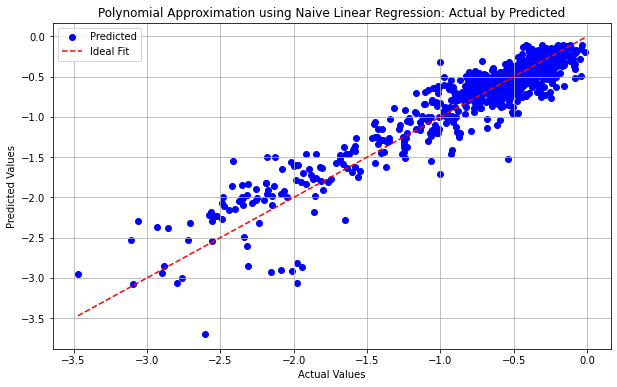

In [53]:
# Example data (replace these with your actual y and yhat values)
# Create a scatter plot for actual vs. predicted
plt.figure(figsize=(10, 6))
plt.scatter(s, shat_lr, color='blue', label='Predicted', marker='o')
plt.plot([min(s), max(s)], [min(s), max(s)], color='red', linestyle='--', label='Ideal Fit')
#plt.scatter(es, eshat, color='blue', label='Predicted', marker='o')
#plt.plot([min(es), max(es)], [min(es), max(es)], color='red', linestyle='--', label='Ideal Fit')

# Add labels and title
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Polynomial Approximation using Naive Linear Regression: Actual by Predicted')
plt.legend()
plt.grid()

# Show the plot
plt.show()

# Try the Levenberg-Marquardt method for nonlinear least squares
* Use the lstsq function, or look into the jaxopt package
* Was less effective than L-BFGS-B, so I will just stick to L-BFGS-B 

In [54]:
#autojacobian_resids = jacobian(nlls_residuals)

#results_lsq = opt.least_squares(nlls_residuals, gammaprime0, args=(X_poly_D, s), 
#                             method='lm', 
#                             jac = autojacobian_resids,
#                             bounds=(-np.inf, np.inf),
#                             max_nfev=1000)
                                

# Scipy minimize seems to fit the data well and finds a minimum (gradient close to 0)

In [55]:
#minimize to fit the coefficients gammaprime 
#Enforce that X@gamma is nonnegative, otherwise we get negative values in the log
nonnegative_b = {'type': 'ineq', 'fun': lambda b: (X_poly_D@b)}

gammaprime_results = opt.minimize(nlls_share_obj, gammaprime0, args=(X_poly_D, s),
                                  constraints = [nonnegative_b],
                       tol=1e-12, jac=autogradient_nlls, hess = autohessian_nlls, method='trust-constr'
)

print("The error is:",  gammaprime_results.fun)
print("The gradient is:",  gammaprime_results.grad)
print("The coefficients in the degree-1 fit are:",  gammaprime_results.x)

shat = np.log(X_poly_D@gammaprime_results.x)

The error is: 45.75189355502218
The gradient is: [5.84948129e-06 6.33041715e-05 2.68816185e-05 6.65497585e-05
 7.08126390e-04 3.03037451e-04 7.45281041e-04 1.33012385e-04
 3.20034710e-04 7.94955058e-04]
The coefficients in the degree-1 fit are: [-0.06492208  0.07132593 -0.04254507 -0.05276808 -0.00885781  0.02737997
 -0.00261827  0.00630371 -0.03944874  0.01855989]


## Actual by predicted plot for my polynomial approximation of $\Phi$, run on the entire sample

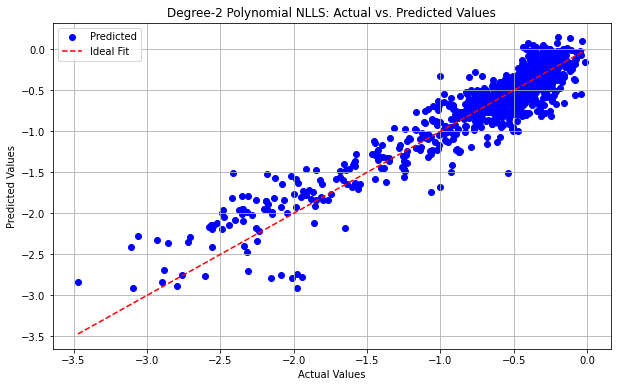

In [56]:
# Example data (replace these with your actual y and yhat values)
# Create a scatter plot for actual vs. predicted
plt.figure(figsize=(10, 6))
plt.scatter(s, shat, color='blue', label='Predicted', marker='o')
plt.plot([min(s), max(s)], [min(s), max(s)], color='red', linestyle='--', label='Ideal Fit')
# Add labels and title
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Degree-2 Polynomial NLLS: Actual vs. Predicted Values')
plt.legend()
plt.grid()
# Show the plot
plt.show()

### Now we have $\hat D_{jt}$.

In [57]:
gammaprime = gammaprime_results.x
#Get Dhat, the elasticities
df['Dhat'] = X_poly_D@gammaprime
#Back out the residuals, epsilons
df['epsilonhat'] = np.log(df['Dhat']) - df['s']
# mean of epsilon is 1e-12 --- good sign
mean_eps = np.mean((df['epsilonhat']))
var_eps = np.var((df['epsilonhat']))
#From here, estimate curlyE which is the sample average of exp(epsilons)
#Turns out to be 1.02.  the mean of a lognormal variable of mean 0 is e^(sigma^2/2). That implies the variance of the epsilons is vey low. 
CurlyEhat = (np.mean(np.exp(df['epsilonhat'])))
lognormal_guess_curlyEhat = np.exp(var_eps/2)
#The theoretial guess for CurlyEhat given epsilon ~ N(0, sigma^2) is very close to the actual curlyEhat, 
#suggesting the epsilons are approximately normally distributed. 
#It follows from the math above that ...
gamma = gammaprime/CurlyEhat
df['df_dm'] = X_poly_D@gamma

Next we want to recover the integral:

$$
\int \frac{\partial}{\partial m_{jt}} f(k_{jt}, l_{jt}, m_{jt}) dm_{jt} = f(k_{jt}, l_{jt}, m_{jt}) + \mathcal C(k_{jt}, l_{jt})
$$

This amounts to integrating the polynomial using $\gamma = \gamma'/\hat {\mathcal E}$.


$$
\text{integral} = \mathcal D(k_{jt}, l_{jt}, m_{jt}) =   \begin{pmatrix} \gamma_0+\gamma_k k_{jt}+\gamma_l l_{jt}+ \frac{\gamma_m}{2} m_{jt} + \gamma_{kk} k_{jt}^2 + \gamma_{ll} l_{jt}^2 \\ \frac{\gamma_{mm}}{3} m_{jt}^2 + \gamma_{kl} k_{jt}l_{jt} + \frac{\gamma_{km}}{2} k_{jt} m_{jt} + \frac{\gamma_{lm}}{2} l_{jt} m_{jt}\end{pmatrix} m_{jt}
$$

Using the above $\mathcal D$, we can calulate $\mathcal Y_{jt} \equiv y_{jt} - \epsilon_{jt} - \mathcal D_{jt} = - \mathcal C(k_{jt}, l_{jt}) + \omega_{jt}$

$$
\hat{\mathcal{Y}}_{jt} = \ln \left( \frac{Y_{jt}}{e^{\hat{\epsilon}_{jt}} e^{\hat{\mathcal{D}}_{jt}}} \right)
$$

but I don't see any reason to take exps and logs. Seems easier to evaluate the log and use
$$
\hat {\mathcal Y_{jt}} \equiv y_{jt} - \hat \epsilon_{jt} - \hat {\mathcal D_{jt}}
$$

In [58]:
#by default,integrate with respect to to xvars[2] = m
def poly_integral_design_matrix(xvars, degree, w_r_t = 2):
    #Get number of observations (n) and number of independent variables (k)
    if xvars.ndim == 1:
        xvars = xvars.reshape(1, -1)
    # Get the number of samples (n) and number of features (m) from X
    n_samples, n_features = xvars.shape
    # Start with a column of ones for the intercept term
    X_poly_integral0 = np.ones((n_samples, 1))
    #Create iterator used to construct polynomial terms
    polynomial_terms = poly_terms(n_features, degree)
    # Generate polynomial terms and interaction terms up to 4th degree
    for terms in  polynomial_terms:  # For degrees 1 to 4
            integration_divisor = terms.count(w_r_t) + 1 #count the number of xvars[2] (i.e. m) appearing in the term and add 1. 
                                                         #Divide the column by that term to campute the "integration scalar"
            xcolumn = np.prod(xvars[:, terms], axis=1).reshape(-1, 1) / integration_divisor
            X_poly_integral0 = np.hstack((X_poly_integral0, xcolumn))
    #Elementwise-multiply all columns in the resulting matrix by m
    X_poly_integral = X_poly_integral0 * xvars[:,w_r_t].reshape(xvars.shape[0],1)
    return X_poly_integral

In [59]:
#Get the design matrix associated with the integral of the polynomial
X_poly_D_integral =  poly_integral_design_matrix(xvars, degree, w_r_t = 2)
#Evaluate it to get curlyD, which is the integral of the log elasticities
df['CurlyD'] = X_poly_D_integral@gamma 
#from here, get CurlyY
df['CurlyY'] = df['y'] - df['epsilonhat'] - df['CurlyD']

# Moving to the second step of GNR

The moments to estimate are: 

$$
\begin{aligned}
(i) \quad E\left[\varepsilon_{j t} \frac{\partial \ln D_r\left(k_{j t}, l_{j t}, m_{j t}\right)}{\partial \gamma}\right] & =0 \\
(ii) \quad E\left[\eta_{j t} k_{j t}^{\tau_k} l_{j t}^{\tau_t}\right] & =0, \\
(iii) \quad E\left[\eta_{j t} \mathcal{Y}_{j t-1}^a\right] & =0,
\end{aligned}
$$

We can "concentrate out" (i) by running the nonlinear least squares regression of of the share equation $s_{jt}$ on $\ln D_{jt}$. 

We can concentrate out (iii) with the following procedure: 
* Guess $\alpha$
* Form $\omega_{jt-1}(\alpha) = \hat{\mathcal Y}_{jt-1} + \operatorname{Poly}_\text{no intercept}^\alpha(k_{jt-1}, l_{jt-1})$
* Calculate $\hat\omega_{jt} = \hat{\mathcal Y_{jt}} + \operatorname{Poly}_\text{no intercept}^\alpha (k_{jt-1}, l_{jt-1})$, plugging in the guessed regression coeficients $\alpha$ and multiplying them with the polynomial design matrix to get the predicted omega.  
* Polynomial-regress $\hat\omega_{jt} \sim \hat\omega_{jt-1}$ to get the innovation $\hat\eta_{jt}$
* Use the moments $\mathbb E\left[ \hat\eta_{jt} X_{jt} \right] = 0$ for all $X\in \left[k, l, k^2, l^2, kl, ..., \text{higher order polynomial terms}\right]$. 

Note that there is NO INTERCEPT in the approximation of the constant of integration. 
Even if we put an intercept in, it would not be identified.

So, we will have as many moments as terms in the polynomial regression. 

In [72]:
#First, drop all NaNs
df['CurlyYprev'] = df.groupby('firm_id')['CurlyY'].shift(1)


df_nonans = df.dropna().copy()

degree_omega = 2
xvars_omega = df_nonans[["k", "l"]].to_numpy()
xvars_prev_omega = df_nonans[["kprev", "lprev"]].to_numpy()

#This polynomial fit has NO INTERCEPT. Even if we wanted an intercept it would not be identified because we end up taking first differences of omega. 
X_poly_omega = poly_design_matrix(xvars_omega, degree_omega)[:, 1:]
Xprev_poly_omega = poly_design_matrix(xvars_prev_omega, degree_omega)[:, 1:]

#Previous CurlyY
CurlyY = df_nonans['CurlyY'].to_numpy()
CurlyYprev = df_nonans['CurlyYprev'].to_numpy()

In [73]:
#Moment error function
def gmm_stage2_error_GNR(alpha, X_poly_omega, Xprev_poly_omega, CurlyY, CurlyYprev):
    #Given alpha, the previous omega is Curly Y + the integration constant curlyC, which is a polynomial fit on lagged k and l
    #Note that there's NO INTERCEPT in this polynomial fit
    #Even if we included an intercept, 
    omegaprev = CurlyYprev + Xprev_poly_omega@alpha
    #Then, calculate current omega = curlyY
    omega = CurlyY + X_poly_omega@alpha
    #Regress omega on omegaprev
    degree_omega = 2
    #xvars
    Xo = poly_design_matrix(omegaprev.reshape(-1, 1), degree_omega)
    #Fit the regression omegaprev ~ polynomial(omega)
    delta = np.linalg.solve(Xo.T@Xo, Xo.T@omega)
    #Get the residual 
    eta = (omega - Xo@delta)
    #calculate the moment errors
    #The moments are simply the polynomial terms in poly(alpha) used to approximate the constant of integration. 
    moment_error = (X_poly_omega.T @ eta)/len(eta)
    return moment_error, delta, eta

def gmm_obj_fcn_GNR(alpha, X_poly_omega, Xprev_poly_omega, CurlyY, CurlyYprev, W):
    #Get the moment errors
    moment_error = gmm_stage2_error_GNR(alpha, X_poly_omega, Xprev_poly_omega, CurlyY, CurlyYprev)[0]
    #caluclate GMM error objective function
    obj = moment_error.T@W@moment_error
    return obj

#Define autogradient
autogradient_GNR = grad(gmm_obj_fcn_GNR)
autohessian_GNR = hessian(gmm_obj_fcn_GNR)

In [91]:
#initial guess for alpha, the polynomial fit for omega
alpha0 = np.ones(X_poly_omega.shape[1])
W0 = np.eye(len(alpha0))

args_GNR = (X_poly_omega, Xprev_poly_omega, CurlyY, CurlyYprev, W0)

gmm_results_GNR = opt.minimize(gmm_obj_fcn_GNR, alpha0, args=args_GNR,
                       tol=1e-24, jac=autogradient_GNR, method='L-BFGS-B'
)

alpha = gmm_results_GNR.x
delta, eta = gmm_stage2_error_GNR(alpha, X_poly_omega, Xprev_poly_omega, CurlyY, CurlyYprev)[1:3]

print("The error is:",  gmm_results_GNR.fun)
print("The gradient is:",  gmm_results_GNR.jac)
print("The coefficients for the integration constant [alpha] are:",  gmm_results_GNR.x)
print("The coefficients for productivity omega [delta] are:",  delta)


The error is: 3.120226541266623e-25
The gradient is: [-7.45458846e-12 -3.35570338e-12 -1.76776613e-10 -7.86614301e-11
 -3.45275550e-11]
The coefficients for the integration constant [alpha] are: [ 0.22962852 -2.6976986  -0.08259352  0.26112497  0.05193076]
The coefficients for productivity omega [delta] are: [1.97089299 0.17895714 0.08014284]
